<a href="https://colab.research.google.com/github/LoPA607/IE643_project/blob/main/Original_Osasis_from_paper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Colab: install required packages
# - diffusers + transformers for Stable Diffusion
# - accelerate to run on GPU
# - ftfy, regex, tqdm for utilities
# - openai/clip for CLIP image encoder
# - safetensors for faster checkpoint load
!pip install --quiet --upgrade pip
!pip install --quiet diffusers transformers accelerate safetensors ftfy regex tqdm
!pip install --quiet git+https://github.com/openai/CLIP.git


  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [2]:
# Imports and device
import os
from PIL import Image
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, utils
import numpy as np
from tqdm import tqdm

# diffusers / schedulers
from diffusers import UNet2DConditionModel, AutoencoderKL, DDIMScheduler, StableDiffusionPipeline, LMSDiscreteScheduler
from transformers import CLIPFeatureExtractor, CLIPModel

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)


Device: cuda


In [3]:
# Helper transforms and display utilities
prep = transforms.Compose([
    transforms.Resize(512, interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.CenterCrop(512),
    transforms.ToTensor()
])

to_pil = transforms.ToPILImage()

def load_image(path, size=512):
    img = Image.open(path).convert("RGB")
    tf = transforms.Compose([
        transforms.Resize(size, interpolation=transforms.InterpolationMode.BICUBIC),
        transforms.CenterCrop(size),
        transforms.ToTensor()
    ])
    return tf(img).unsqueeze(0).to(device)  # 1x3xHxW

def show_tensor(t):
    t = t.detach().clamp(0,1).cpu().squeeze(0)
    display(to_pil(t))


In [ ]:
# Load CLIP (image encoder) for semantic embeddings (image-only)
print("Loading CLIP model...")
clip_model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32").to(device)
clip_dim = clip_model.config.projection_dim  # usually 512 or 768

# Load Stable Diffusion components (Autoencoder VAE + UNet)
# We'll use a compact checkpoint for Colab; you can switch to other HF IDs if you prefer.
print("Loading Stable Diffusion V1.5 components (autoencoder + unet + scheduler)...")
from diffusers import AutoencoderKL, UNet2DConditionModel

# We will download a small-ish official pipeline via diffusers (this will also download weights)
from diffusers import StableDiffusionPipeline
pipe = StableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5", torch_dtype=torch.float16).to(device)
vae = pipe.vae  # AutoencoderKL
unet = pipe.unet  # UNet model used for denoising (conditioned on text by default but we will not use text)
scheduler = DDIMScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", clip_sample=False)
# scheduler config can be adjusted; later we'll create timesteps and use it for encode/decode
print("Loaded pipeline components.")


In [5]:
# Utility to encode image to latent space (via SD's encoder) and decode latent -> image via VAE
def image_to_vae_latent(image_tensor):
    # image_tensor: 1x3xHxW, values 0..1
    with torch.no_grad():
        img = 2.0 * image_tensor - 1.0  # map to [-1,1]
        latent = vae.encode(img.half()).latent_dist.sample()  # shape: 1xCxhxw
        latent = latent * 0.18215
        return latent  # keep dtype half for speed

def vae_latent_to_image(latent):
    with torch.no_grad():
        lat = latent / 0.18215
        img = vae.decode(lat.half()).sample
        img = (img / 2 + 0.5).clamp(0,1)
        return img

# DDIM encode: given a clean latent z_0 and a target timestep t_index, produce z_t
# We'll use the DDIM scheduler (deterministic forward) to get x_t. For diffusers' DDIMScheduler
def ddim_forward_noise(z0, t_index, scheduler):
    # z0: latent in model space (same as UNet input) shape 1xCxhxw
    # We can simulate forward diffusion by adding noise according to scheduler's alpha_cumprod
    device = z0.device
    alphas_cumprod = scheduler.alphas_cumprod.to(device)
    alpha_t = alphas_cumprod[t_index]  # scalar
    noise = torch.randn_like(z0)
    z_t = torch.sqrt(alpha_t) * z0 + torch.sqrt(1 - alpha_t) * noise
    return z_t, noise


In [6]:
# CLIP-based semantic embedding (image-only)
def clip_image_embed(image_tensor):
    # image_tensor: 1x3xHxW, values 0..1
    # resize to CLIP expected size and normalize
    # Use CLIP feature extractor to process PIL or numpy; we'll do manual resizing + normalization
    img = F.interpolate(image_tensor, size=(224,224), mode='bilinear', align_corners=False)
    img = img * 255.0
    img = img.type(torch.uint8).permute(0,2,3,1).cpu().numpy()[0]  # HWC uint8
    # CLIPFeatureExtractor expects PIL images; but we can use CLIPModel's preprocess if available.
    # We'll do simple path: use torchvision transforms matching CLIP normalization:
    tf = transforms.Compose([
        transforms.Resize(224, interpolation=transforms.InterpolationMode.BICUBIC),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize((0.48145466, 0.4578275, 0.40821073),
                             (0.26862954, 0.26130258, 0.27577711))
    ])
    # Convert back to tensor and move to device
    pil = Image.fromarray(img)
    x = tf(pil).unsqueeze(0).to(device)
    with torch.no_grad():
        emb = clip_model.get_image_features(x)  # 1xC
        emb = F.normalize(emb, dim=-1)
    return emb  # 1xC


In [ ]:
# Detect CLIP embedding size dynamically
with torch.no_grad():
    dummy_img = torch.randn(1, 3, 224, 224).to(device)
    emb_dim = clip_model.get_image_features(dummy_img).shape[-1]
print("Detected CLIP embedding dimension:", emb_dim)

# Redefine SPN to use that embedding size
class SmallSPN(nn.Module):
    def __init__(self, in_ch, mid_ch=64, sem_dim=512):
        super().__init__()
        self.down1 = nn.Conv2d(in_ch, mid_ch, 3, padding=1)
        self.down2 = nn.Conv2d(mid_ch, mid_ch, 3, padding=1)
        # Fix: Changed ConvTranspose2d to Conv2d to maintain spatial resolution
        self.up1 = nn.Conv2d(mid_ch, mid_ch, 3, padding=1) # Replaced nn.ConvTranspose2d(mid_ch, mid_ch, 4, stride=2, padding=1)
        self.out = nn.Conv2d(mid_ch, in_ch, 3, padding=1)
        self.act = nn.ReLU()
        self.mod = nn.Sequential(nn.Linear(sem_dim, mid_ch), nn.ReLU())

    def forward(self, x, sem_delta=None):
        h = self.act(self.down1(x))
        h = self.act(self.down2(h))
        if sem_delta is not None:
            m = self.mod(sem_delta).unsqueeze(-1).unsqueeze(-1)
            h = h * (1.0 + m)
        h = self.act(self.up1(h))
        out = self.out(h)
        return x + out  # residual correction for sharpness


# instantiate SPN matching latent channels (UNet latent channels are 4x downsample of image)
# For Stable Diffusion VAE latent channels are 4 (C=4), spatial size 64x64 for 512 input.
latent_channels = vae.config.latent_channels if hasattr(vae.config, "latent_channels") else 4
spn = SmallSPN(in_ch=latent_channels, mid_ch=128, sem_dim=emb_dim).to(device)
print("SPN instantiated with sem_dim =", emb_dim)

# Add a linear projection layer to transform CLIP image embeddings (emb_dim=512)
# to the Stable Diffusion UNet's expected text embedding dimension (768).
clip_to_text_projection = nn.Linear(emb_dim, 768).to(device)
print(f"CLIP to Text projection layer created: {emb_dim} -> 768")

In [8]:
# Stylize function: encode content -> structural latent at chosen timestep, then decode with style semantics & SPN guidance
@torch.no_grad()
def stylize(content_img_path, style_img_path, t_struct_idx=50, ddim_steps=50, spn_scale=0.8, guidance_scale=7.5):
    # 1) load images
    x_c = load_image(content_img_path)  # 1x3xHxW
    x_s = load_image(style_img_path)

    # 2) obtain VAE latents (z0) for both images
    z0_c = image_to_vae_latent(x_c)  # 1xCxhxw
    z0_s = image_to_vae_latent(x_s)

    # 3) compute semantic embeddings via CLIP and delta semantic
    sem_c = clip_image_embed(x_c)  # 1x512
    sem_s = clip_image_embed(x_s)

    sem_delta = ((sem_s - sem_c)*3).to(device)  # 1x512, direction in semantic space

    # Project the 512-dim sem_delta to 768-dim to be compatible with the UNet's text encoder input
    sem_delta_projected = clip_to_text_projection(sem_delta.float()).half() # 1x768

    # 4) forward encode content latent to timestep t_struct to get z_t_struct (approx)
    # choose scheduler timesteps array
    scheduler.set_timesteps(ddim_steps)
    timesteps = scheduler.timesteps  # length = ddim_steps; values descending
    # we map t_struct_idx to an index in the scheduler timesteps range
    t_idx = max(0, min(len(timesteps)-1, t_struct_idx))
    t_val = timesteps[t_idx].to(device)
    # approximate forward (gaussian)
    z_t, noise = ddim_forward_noise(z0_c, t_idx, scheduler)  # z_t is noisy latent at timestep t_idx

    # 5) reverse decode from z_t -> z0 using UNet (DDIM) with SPN guidance:
    z_cur = z_t.clone()

    # Define a dummy unconditional text embedding with the correct shape (batch_size, sequence_length, hidden_size)
    # For Stable Diffusion v1.5, sequence_length is typically 77 and hidden_size is 768.
    unconditional_embedding = torch.zeros((1, 77, 768), device=device, dtype=torch.float16)

    for i_index in range(t_idx, -1, -1):  # iterate backwards (coarse -> fine)
        t = timesteps[i_index].to(device)
        # Prepare model input
        z_in = z_cur
        t_tensor = torch.tensor([int(t.item())], device=device, dtype=torch.long)

        # Predict noise with UNet, using the dummy unconditional embedding
        # Generate conditional embedding by modulating with sem_delta_projected
        # sem_delta_projected is (1, 768). unsqueeze(1) makes it (1, 1, 768).
        # This will broadcast correctly with unconditional_embedding (1, 77, 768)
        cond_embedding = unconditional_embedding + sem_delta_projected.unsqueeze(1) * 0.5

        # Two passes: unconditional & conditional
        pred_uncond = unet(z_in.half(), t_tensor, unconditional_embedding).sample
        pred_cond   = unet(z_in.half(), t_tensor, cond_embedding).sample

        # Combine them (like CFG)
        guidance_scale = 8.0  # try 6–9 for high style
        pred = pred_uncond + guidance_scale * (pred_cond - pred_uncond)

        # SPN correction computed on current latent
        # Note: sem_delta here is still 1x512, which is correct for SPN's sem_dim=512
        spn_corr = spn(z_in.float(), sem_delta.float()).half()
        # combine pred and spn guidance: alter predicted z or add to z_in
        # Simple scheme: correct the current latent before the next step
        z_corrected = z_in + spn_scale * spn_corr

        # DDIM single-step reverse update (simplified)
        model_output = pred
        step_output = scheduler.step(model_output, i_index, z_corrected, eta=0.0)
        z_cur = step_output.prev_sample

    # 6) decode final latent to RGB
    out_img = vae_latent_to_image(z_cur)
    return out_img

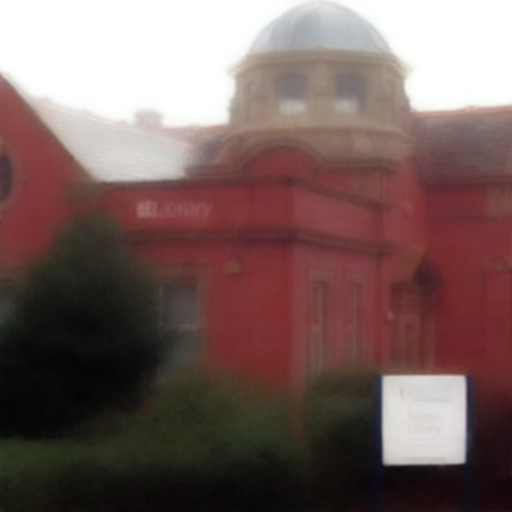

In [9]:
# Upload or mount your images to Colab and provide paths here
content_path = "/content/clean.jpg"  # replace with your file path
style_path = "/content/hidemotionblur.png"      # replace with your file path

# Example run (may take ~couple minutes)
out = stylize(
    content_path,
    style_path,
    t_struct_idx=15,
    ddim_steps=50,
    spn_scale=0.05,
    guidance_scale=6
)
show_tensor(out[0:1])


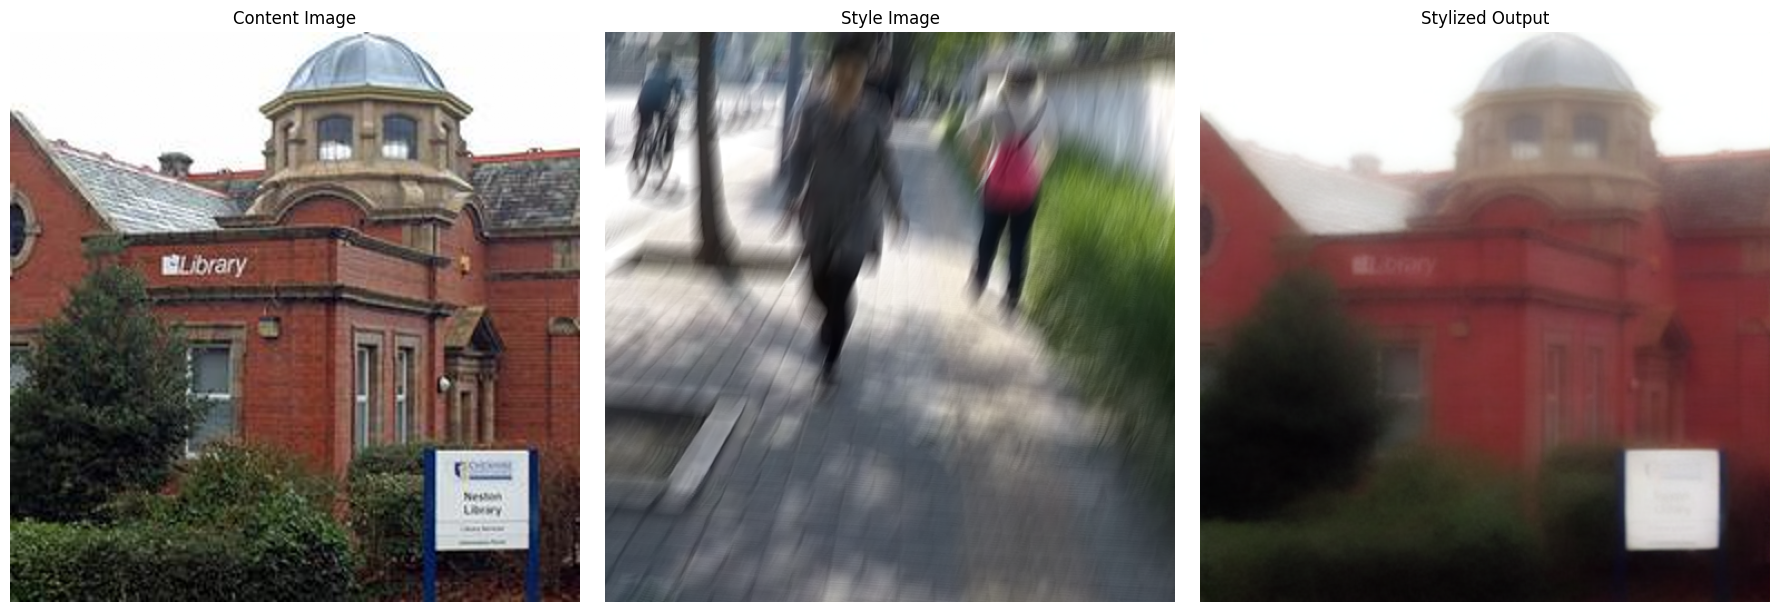

In [10]:
import matplotlib.pyplot as plt

# Assuming content_path and style_path are set from previous cells
# If not, please set them here:
# content_path = "/content/clean.jpg"
# style_path = "/content/hidemotionblur.png"

# Load original content and style images for display
original_content_img = load_image(content_path)
original_style_img = load_image(style_path)

# Ensure 'out' variable holds the stylized image from a previous run,
# or re-run the stylize function if 'out' is not defined.
# For example:
# out = stylize(
#     content_path,
#     style_path,
#     t_struct_idx=25,
#     ddim_steps=50,
#     spn_scale=0.25,
#     guidance_scale=8.0
# )

plt.figure(figsize=(18, 6)) # Adjust figure size as needed

plt.subplot(1, 3, 1) # 1 row, 3 columns, 1st plot
# Ensure float32 for imshow
plt.imshow(original_content_img.cpu().squeeze().permute(1, 2, 0).float().numpy())
plt.title('Content Image')
plt.axis('off')

plt.subplot(1, 3, 2) # 1 row, 3 columns, 2nd plot
# Ensure float32 for imshow
plt.imshow(original_style_img.cpu().squeeze().permute(1, 2, 0).float().numpy())
plt.title('Style Image')
plt.axis('off')

plt.subplot(1, 3, 3) # 1 row, 3 columns, 3rd plot
# Ensure float32 for imshow
plt.imshow(out.cpu().squeeze().permute(1, 2, 0).float().numpy())
plt.title('Stylized Output')
plt.axis('off')

plt.tight_layout()
plt.show()